In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from os.path import join as oj
import numpy as np
from copy import deepcopy
plt.style.use('dark_background')
import data
import pickle as pkl
import viz
from util.style import *
from util import analyze_helper, train
from sklearn import metrics
import config
import pandas as pd
from tqdm import tqdm
outcome_def = 'y_consec_thresh'
out_dir = oj('/scratch/users/vision/abc', 'may7_1') # mar7_2 is 0.95, mar8_1 is 0.96
results = analyze_helper.load_results(out_dir)

# get data
df = data.get_data()
n = df.shape[0]
df_cv = df[df.valid == 1] # exclude test cells, short/long tracks, hotspots
X, y, norms = analyze_helper.normalize(df_cv, outcome_def)

# select model
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
accs = np.array(r.accuracy)
# model_name = idx[0]
model_name = 'mlp2_17_select_lasso=7_ros=1_h=0_cal=True'
print('using model', model_name)
for i in range(5):
    print(f'\t{accs[i]:.3f}', idx[i])
    

# load model + preds
d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
preds_cv = d_full_cv[model_name].values
preds_proba_cv = d_full_cv[model_name + '_proba'].values

results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
assert np.sum(idxs_cv == np.arange(idxs_cv.size)) == idxs_cv.size, \
       'points not in same order'
assert np.mean(preds_cv==y_full_cv) == np.average(results_individual['cv']['accuracy'], 
                                               weights=results_individual['num_pts_by_fold_cv']), \
        'did not properly load model/data'
tp, tn, fp, fn = analyze_helper.calc_errs(preds_cv, y_full_cv)
print('succesfully loaded!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator _SigmoidCalibration from version 0.22 when using version 

using model mlp2_17_select_lasso=7_ros=1_h=0_cal=True
	0.760 svm_17_select_lasso=9_ros=1.2_h=1_cal=True
	0.760 svm_17_select_lasso=9_ros=1_h=1_cal=True
	0.759 mlp2_17_select_lasso=9_ros=1_h=1_cal=True
	0.758 mlp2_17_select_lasso=15_ros=1_h=0_cal=True
	0.757 mlp2_17_select_lasso=9_ros=1_h=0_cal=True
succesfully loaded!


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator _SigmoidCalibration from version 0.22 when using version 

# accuracies on different test datasets

**calculate predictions on diff datasets**

In [3]:
orig_dset = 'clath_aux+gak_a7d2'
normalize_by_train = False
df = data.get_data()

# training data
CELLS_TRAIN = config.DSETS[orig_dset]['train']
df_train = df[df.cell_num.isin(CELLS_TRAIN)]
X_train = df_train[data.get_feature_names(df_train)]
X_mean_train = X_train.mean()
X_std_train = X_train.std()

# testing data
CELLS_TEST = config.DSETS[orig_dset]['test']
df_test = df[df.cell_num.isin(CELLS_TEST)]
X_test = df_test[data.get_feature_names(df_test)]
if normalize_by_train:
    X_test = (X_test - X_mean_train) / X_std_train
else:
    X_test = (X_test - X_test.mean()) / X_test.std()
y_test = df_test[outcome_def].values

# get model
m0 = results_individual['imps']['model'][0]
feat_names_selected = results_individual['feat_names_selected']
preds_test = m0.predict(X_test[feat_names_selected]) 
preds_proba_test = m0.predict_proba(X_test[feat_names_selected]) [:, 1]

# set up lists
dsets = ['validation', 'test']
ys_list = [y_full_cv, y_test]
preds_list = [preds_cv, preds_test]
preds_proba_list = [preds_proba_cv, preds_proba_test]
Y_max_list = [df_cv['Y_max'], df_test['Y_max']]

# loop over new datasets
dset_names = [k for k in config.DSETS.keys() if not k == orig_dset]
for dset_name in tqdm(dset_names):
    df_new = data.get_data(dset=dset_name, use_processed=True,
                           use_processed_dicts=True, outcome_def=outcome_def,
                           previous_meta_file='processed/metadata_orig.pkl')
    df_new = df_new[df_new['valid']] # exclude test cells, short/long tracks, hotspots
    X_new = df_new[data.get_feature_names(df_new)]
    if normalize_by_train:
        X_new = (X_new - X_mean_train) / X_std_train
    else:
        X_new = (X_new - X_new.mean()) / X_new.std()
    y_new = df_new[outcome_def].values
    preds_new = m0.predict(X_new[feat_names_selected]) 
    preds_proba_new = m0.predict_proba(X_new[feat_names_selected])[:, 1]
    Y_max_list.append(df_new['Y_max'])

    dsets.append(dset_name)
    ys_list.append(deepcopy(y_new))
    preds_list.append(deepcopy(preds_new))
    preds_proba_list.append(deepcopy(preds_proba_new))

100%|██████████| 6/6 [00:05<00:00,  1.34it/s]


**show metrics on different dsets**

In [26]:
def roundd(x):
    try:
        return x.round(2)
    except:
        return [y.round(2) for y in x]
    
def mean_diff(vals, preds):
    return np.mean(vals[preds==1]) - np.mean(vals[preds==0])

r_long = {}
n = len(dsets)
for s in train.scorers:
    if s == 'roc_auc':
        r_long[s] = [roundd(metrics.roc_auc_score(ys_list[i],
                                                  preds_proba_list[i])) for i in range(n)]
    elif 'curve' not in s and 'acc' in s:
        r_long[s] = [roundd(train.scorers[s](ys_list[i], preds_list[i])) for i in range(n)]        
r_long['diff_aux_max_by_class'] = [mean_diff(Y_max_list[i], preds_list[i]) for i in range(n)]
r_long['aux+ ratio'] = [np.mean(ys_list[i]) for i in range(n)]

r = pd.DataFrame.from_dict(r_long).transpose()
r.columns = dsets
r.round(2)

,validation,test,clath_aux+gak,clath_aux+gak_a7d2_new,clath_aux+gak_new,clath_gak,clath_pi4p_notreatment,ap2_pi4p
balanced_accuracy,0.74,0.77,0.75,0.66,0.76,0.69,0.75,0.79
accuracy,0.74,0.69,0.75,0.64,0.76,0.67,0.54,0.58
roc_auc,0.81,0.88,0.81,0.71,0.83,0.74,0.84,0.83
diff_aux_max_by_class,481.56,552.96,1346.36,1838.80,1253.91,509.87,5276.23,6708.42
aux+ ratio,0.50,0.22,0.60,0.70,0.52,0.40,0.96,1.00


In [ ]:
print(r.to_latex())

# diff dataset summaries

In [26]:
# process original data (and save out lifetime thresholds)
dset_names = [k for k in sorted(config.DSETS.keys()) if not 'pi4p' in k]
# dsets = ['clath_aux', 'orig_gak', 'clath_aux_no_a7d2', 'clath_aux_a8', 'clath_pi4p_notreatment']

NUM_DSETS = len(dset_names)
rs = {
    k: [] for k in ['X_mean', 'Y_max']
}
ds = {
    k: [] for k in ['lifetime']
}
for dset in tqdm(dset_names):
    # process new data (using lifetime thresholds from original data)
    df = data.get_data(dset=dset,
                  previous_meta_file='processed/metadata_orig.pkl')
    for k in rs.keys():
        rs[k].append(df[k].mean())
    for k in ds.keys():
        ds[k].append(df[k])

100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


**means of some features**

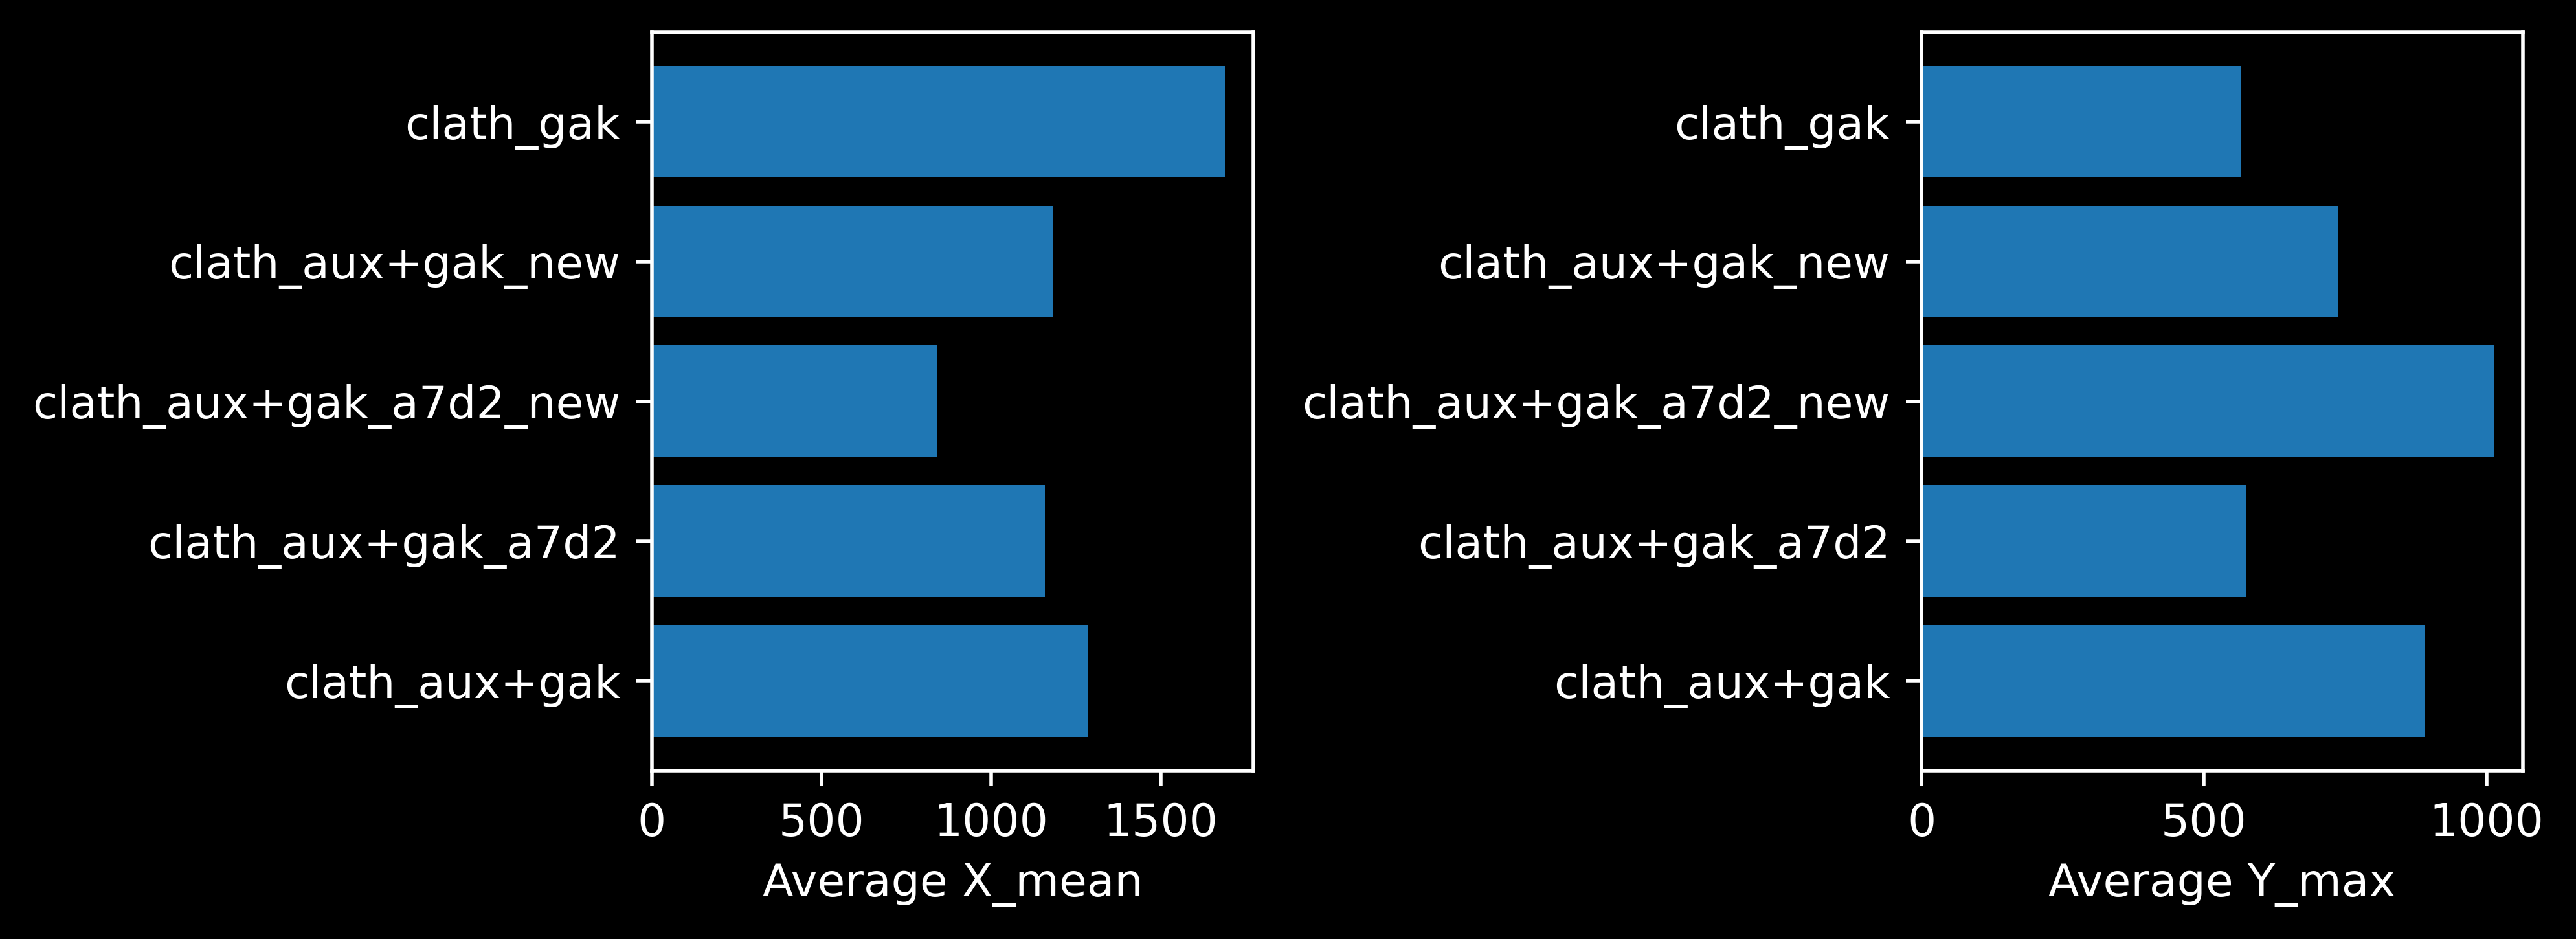

In [6]:
R, C = 1, 2
plt.figure(figsize=(8, 3), dpi=500)
for i, k in enumerate(rs.keys()):
    plt.subplot(R, C, i + 1)
    plt.barh(dset_names, rs[k], color=cb)
    plt.xlabel('Average ' + k)
plt.tight_layout()
plt.show()

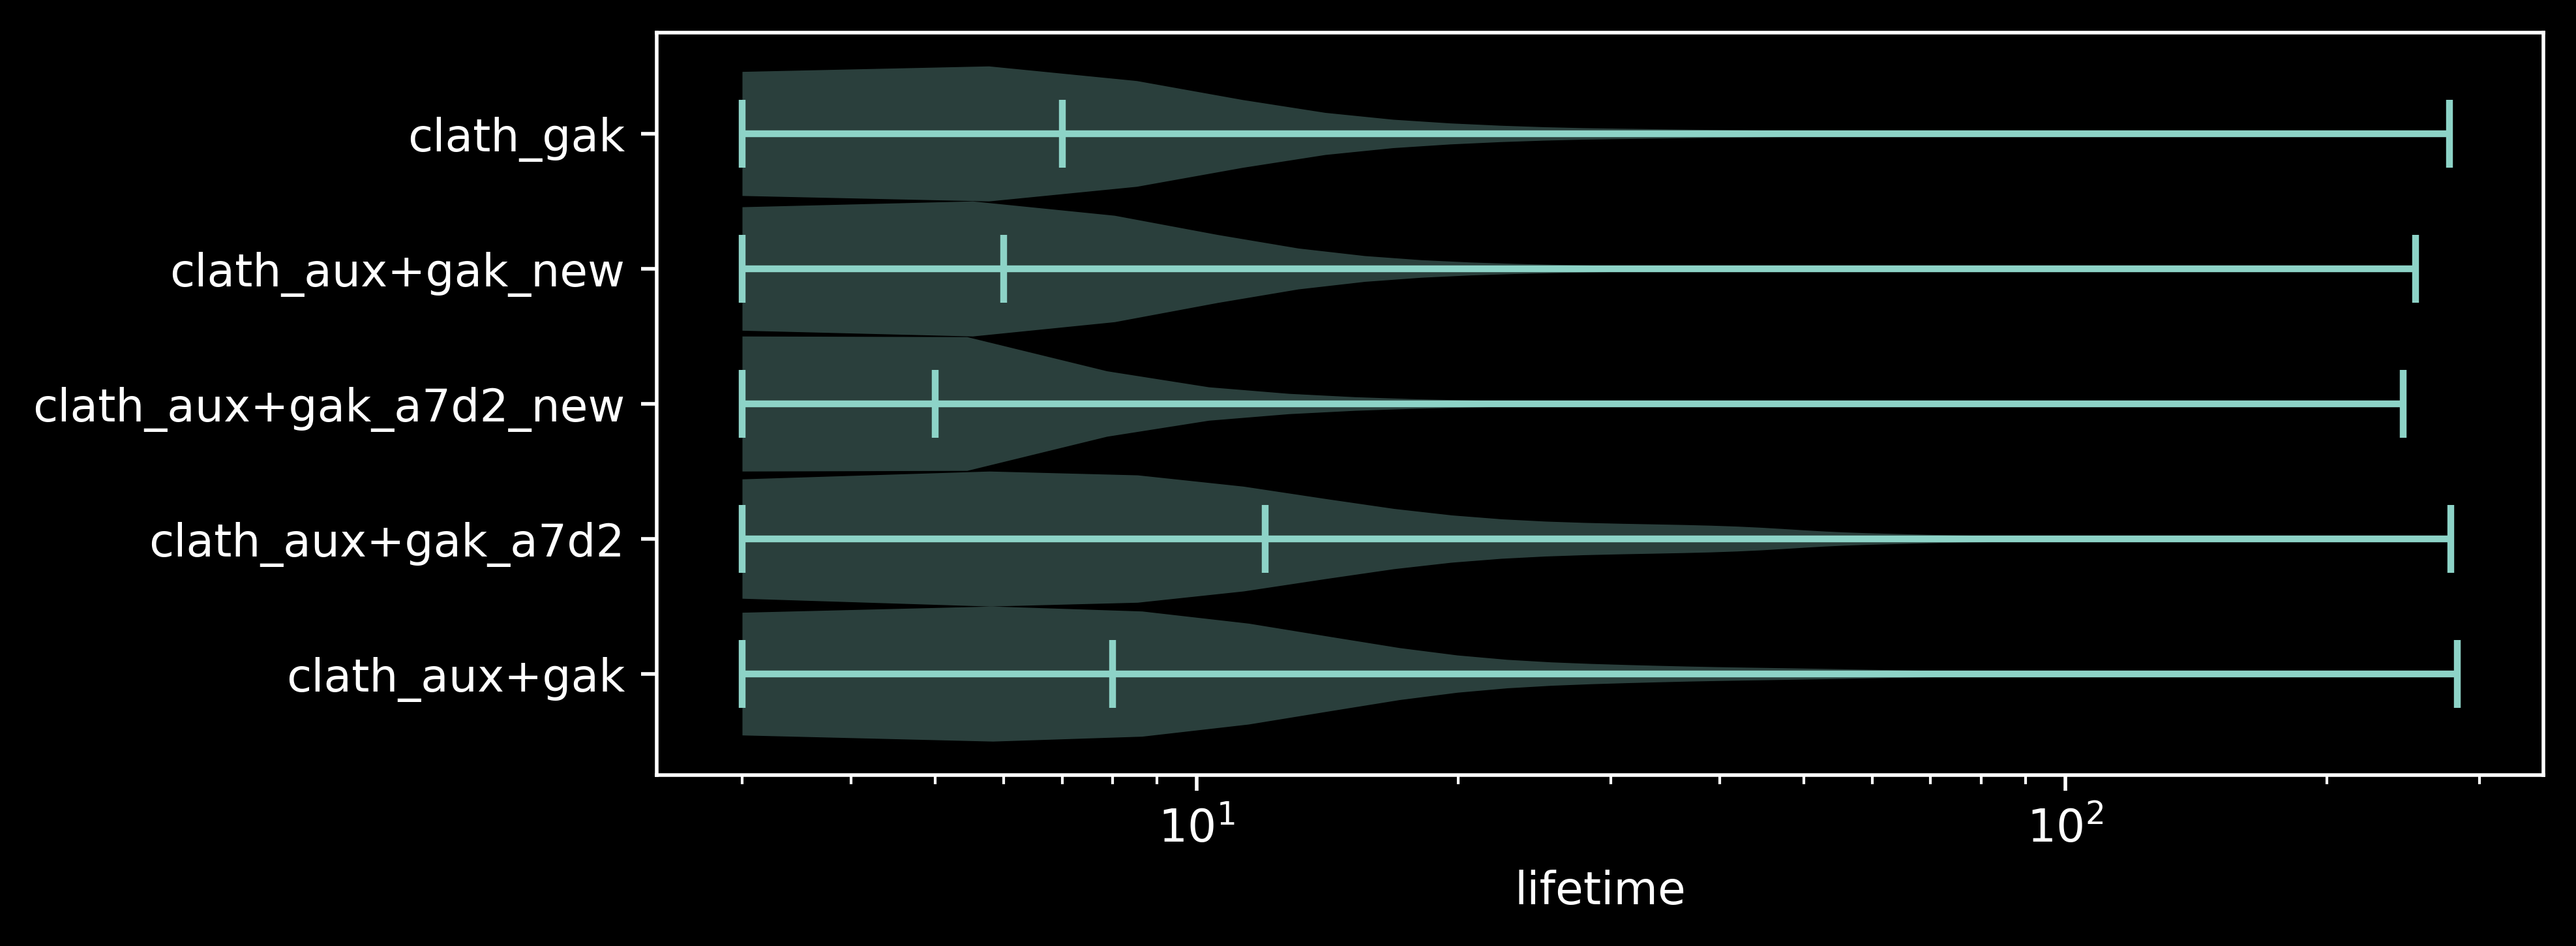

In [27]:
R, C = 1, len(ds.keys())
plt.figure(figsize=(8, 3), dpi=500)
for i, k in enumerate(ds.keys()):
    ax = plt.subplot(R, C, i + 1)
    # plt.barh(dset_names, [np.mean(x) for x in ds[k]], color=cb)
    ax.violinplot([val.values for val in ds[k]], vert=False, widths=1, showmedians=True, showextrema=True) #, quantiles=[25, 50])
    plt.yticks(np.arange(len(dset_names)) + 1, dset_names)
    plt.xlabel(k)
    plt.xscale('log')
plt.tight_layout()
plt.show()

# lower res data

In [ ]:
accs = []
DOWNSAMPLE_list = range(1, 21)
for DOWNSAMPLE in tqdm(DOWNSAMPLE_list):

    # downsample
    df_cv = deepcopy(df[df.valid == 1]) # exclude test cells, short/long tracks, hotspots
    df_cv['X'] = [x[::DOWNSAMPLE] for x in df_cv.X]
    df_cv['X_extended'] = [x[::DOWNSAMPLE] for x in df_cv.X_extended]
    df_cv['lifetime'] = [len(x) for x in df_cv.X]
    df_cv = data.add_features(df_cv)


    # get data
    X, y, norms = analyze_helper.normalize(df_cv, outcome_def)
    d_full_cv, idxs_cv = analyze_helper.get_data_over_folds(model_name, out_dir, df_cv.cell_num, X, y)
    y_full_cv = df_cv[outcome_def].iloc[idxs_cv].values.astype(np.int)
    preds = d_full_cv[model_name].values
    preds_proba = d_full_cv[model_name + '_proba'].values
    acc = np.mean(preds==y_full_cv)
    accs.append(acc)
#     print(f'downsampling rate {DOWNSAMPLE} acc {acc.round(3)}')

In [ ]:
plt.figure(dpi=300)
plt.plot(DOWNSAMPLE_list, accs, '.-', color=cb)
plt.xlabel('Downsamping factor')
plt.ylabel('Accuracy on difficult region')
plt.savefig('downampling.pdf')
plt.show()

In [ ]:
# plot of example track
track_num = 3
ex = deepcopy(df[df.valid == 1]).iloc[track_num]
viz.plot_example(ex)
plt.plot(np.arange(len(ex.X))[::3], ex.X[::3], 'o', color='w', alpha=0.5)
plt.show()